In [1]:
import sys
sys.path.append('C:\\Users\\cysdh\\anaconda3\\Lib\\site-packages')

import cv2
import numpy as np
import scipy
from scipy.stats import lognorm
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

In [2]:
def fcall(img_nm):
    
    #대상 이미지 파일의 확장자를 확인할 것.
    filename = img_nm+'.png'

    # Load the image and convert it to grayscale:
    image = cv2.imread(filename)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    #cv2.THRESH_BINARY 인지 cv2.THRESH_BINARY_INV 꼭 확인할것!
    ret, thresh = cv2.threshold(gray_image, 50, 255, cv2.THRESH_BINARY_INV)
    
    return thresh

In [3]:
def find_a_contour(thresh):
    contours, hierarchy = cv2.findContours(
        thresh, 
        cv2.RETR_EXTERNAL, 
        cv2.CHAIN_APPROX_NONE)
    ncnt = len(contours[:]) #ncnt = number of contour lines
    chk = 0 #chk은 w번째 경계면을 이루는 좌표의 갯수이다
    set = 0 #set이 내가 찾고 싶은 경계면의 번호이다
    for w in range(ncnt):
       if chk < len(contours[w]):
            chk = len(contours[w])
            set = w
    # 찾은 contour 좌표를 contour_array에 저장한다
    contour_array=contours[set][:,0,:]

    # 폐합된(closed) 다각형(polygon) 좌표군을 생성한다.
    polyg = np.append(contour_array, contour_array[0,:].reshape(1,2), axis=0)
    
    # Equivalent diameter를 구한다.
    area = cv2.contourArea(contours[set])
    equi_diameter = np.sqrt(4*area/np.pi)
    
    return contour_array, polyg, equi_diameter


In [4]:
def find_eqdpt(polyg, numOfSegments):

    #Find Contour Perimeter
    perimeter = cv2.arcLength(polyg,True)

    #Find Segment length
    SegLength = perimeter/numOfSegments

    lastpt = polyg[0:1] #제일 첫 point를 last point로 설정
    eqdpt  = polyg[0:1]
    polyIdx = 0
    lenToGo = SegLength

    while len(eqdpt)<numOfSegments:
        lenOnPolyline = np.linalg.norm(polyg[polyIdx+1]-lastpt)
        if lenOnPolyline > lenToGo:
            unitv = polyg[polyIdx+1]-lastpt
            unitv = unitv / np.linalg.norm(unitv)       
            lastpt = unitv*lenToGo + lastpt
            eqdpt = np.append(eqdpt,lastpt.reshape(1,2),axis=0)
            lenToGo = SegLength
        else:
            lenToGo = lenToGo - lenOnPolyline
            polyIdx += 1
            lastpt = polyg[polyIdx]    
    
    return eqdpt

In [5]:
def trans_eqdpt(eqdpt, polyg, contour_array):
    # Find Centroid
    M = cv2.moments(contour_array)
    cX = np.int32(M["m10"]/M["m00"])
    cY = np.int32(M["m01"]/M["m00"])

    # Translate Contour points
    centroid = np.empty(contour_array.shape)
    centroid[:,0] = cX
    centroid[:,1] = cY
    contour_array = contour_array - centroid

    centroid = np.empty(polyg.shape)
    centroid[:,0] = cX
    centroid[:,1] = cY
    polyg = polyg - centroid
        
    centroid = np.empty(eqdpt.shape)
    centroid[:,0] = cX
    centroid[:,1] = cY
    
    eqdpt = eqdpt - centroid
    
    return eqdpt, polyg, contour_array

In [6]:
def find_FD(eqdpt,sig_num):

    # 푸리에 변환에 사용할 절점 g의 갯수 = M
    M = len(eqdpt)    
    
    #2차원 Fourier 변환을 위한 준비(복소수형태로 좌표를 변환시킴) --> fft 변환 --> fourier_result에 coef값 저장
    eqdpt_complex = np.empty(eqdpt.shape[:-1],dtype=complex)
    eqdpt_complex.real = eqdpt[:,0]
    eqdpt_complex.imag = eqdpt[:,1]

    fft_result = np.fft.fft(eqdpt_complex)  # np.fft.fft로 구한 coef값은 1/M되지 않았다.
    fft_result = fft_result/M  # 1/M로 나눠주었다.
    fftshifted = np.fft.fftshift(fft_result)  # fftshift가 zero-freq를 중앙으로 위치시킨다.
    
    #sig_num 가 몇개를 추출할지 결정 (pair의 갯수임)
    if (len(fftshifted) % 2) == 0:
        center_index = len(fftshifted)/2
    else:
        center_index = (len(fftshifted)+1)/2
    start = np.int32(center_index - sig_num)
    end   = np.int32(center_index + sig_num) +1

    #print('center,start,end=',center_index,start,end)
    
    G = fftshifted[start:end]  #start와 end 사이의 중앙값이 가장 큰 coef를 가진다.
    
    # Calculate Magnitude of Fourier Descriptor Coefficients
    G_real = G.real
    G_imag = G.imag
    G_mag  = np.sqrt(G_real**2+G_imag**2)
    
    return G_mag, G_real, G_imag, fft_result, fftshifted

In [7]:
def dcfft(img_nm,numOfseg,sig_num):

    thresh = fcall(img_nm)
    
    #입자 이미지의 경계면 좌표를 찾는다.
    contour_array, polyg, eqdia = find_a_contour(thresh)
    
    print(img_nm,eqdia,'Equ_dia')
    
    #앞서 얻은 경계면 좌표 간격은 일정하지 않다. 이를 일정한 간격이 되도록 좌표를 다시 찾는다.
    #numOfSegments = by input param   #등간격 세그먼트의 숫자를 지정한다. 2^n 으로 지정
    eqdpt = find_eqdpt(polyg, numOfseg)
    
    #좌표군들의 도심이 원점이 되도록 이동(translation)시킨다.
    eqdpt, polyg, contour_array = trans_eqdpt(eqdpt, polyg, contour_array)

    #FFT를 실시하여 Fourier Descriptor를 찾는다.
    #sig_num = by input param         #중심을 기준으로 추출할 FD의 갯수를 정한다.
    idx = pd.DataFrame({'idx':np.arange(-sig_num,sig_num+1)})
    
    a,b,c,d,e = find_FD(eqdpt,sig_num)
    
    df1 = pd.DataFrame({'mag':a,'real':b,'imag':c})
    df2 = pd.DataFrame({'fft_result':d,'fftshift_result':e})
    df3 = pd.DataFrame({'x0':eqdpt[:,0],'y0':eqdpt[:,1]})
    
    return df1, df2, df3, eqdia

In [8]:
def fdrecon(title,N,sig_num,real,imag):
    
    x1 = []
    y1 = []
    
    for k in np.arange(0,N,1):
        t = k/N
        x = 0
        y = 0

        for m in np.arange(-sig_num,sig_num+1):
            phi = 2 * np.pi * m * t
        
            A = real.loc[m,title]
            B = imag.loc[m,title]
        
            x += A*np.cos(phi)-B*np.sin(phi)
            y += A*np.sin(phi)+B*np.cos(phi)
    
        x1.append(x)
        y1.append(y)
    
    df = pd.DataFrame({'x1':x1,'y1':y1})
    
    return df

In [9]:
def std_image(mylist):
    
    #0차항 제거
    for k in range(len(mylist)):
        for i in range(41):
            if i == 19:
                imag[f'{mylist[k]}'][i-20] = 0        # 0차항 제거
                real[f'{mylist[k]}'][i-20] = 0
                mag[f'{mylist[k]}'][i-20] = 0
            else:
                pass
    
    std_imag = imag.mean(axis='columns')
    std_real = real.mean(axis='columns')
    
    df = pd.DataFrame({'std_imag':std_imag,'std_real':std_real})
    
    x1=[]
    y1=[]
    
    for 
    

In [10]:
def mean_and_std(df):
    # Set the diagonal and upper triangular values to NaN
    df = df.where(np.triu(np.ones(df.shape), k=1).astype(bool))
    # Get the mean and standard deviation of the remaining values
    mean = df.stack().mean()
    std = df.stack().std()
    return mean, std

In [11]:
numOfseg = 128   #[중요] 등간격 세그먼트의 숫자를 지정한다. 2^n 으로 지정
sig_num = 20      #[중요] Zero-Freq 중심을 기준으로 아래 위로 추출할 FD의 갯수를 정한다. (Pair의 숫자임)

In [12]:
import glob
mylist = [f for f in sorted(glob.glob("*.png"))]  #읽어들일 파일의 확장자 확인할것

mag = pd.DataFrame({'idx':np.arange(-sig_num,sig_num+1)})
real = mag
imag = mag

x0 = pd.DataFrame()
y0 = pd.DataFrame()
eqdia = pd.DataFrame()

for img_nm in mylist[:]:
    print(img_nm[:-4])
    title = img_nm[:-4]
    df1,df2,df3,eqd = dcfft(title,numOfseg,sig_num)
    mag  = pd.concat([mag, df1['mag']],axis=1)
    real = pd.concat([real,df1['real']],axis=1)
    imag = pd.concat([imag,df1['imag']],axis=1)
    x0 = pd.concat([x0,df3['x0']],axis=1)
    y0 = pd.concat([y0,df3['y0']],axis=1)
    d = pd.DataFrame([eqd])
    eqdia = pd.concat([eqdia,d],axis=1)
    
mag = mag.set_index('idx')    
real = real.set_index('idx')
imag = imag.set_index('idx')

mag.columns = mylist
real.columns = mylist
imag.columns = mylist
x0.columns = mylist
y0.columns = mylist
eqdia.columns = mylist

#display(mag,real,imag)

[100]_re
[100]_re 969.0767034698738 Equ_dia
[103]_re
[103]_re 854.6107227092451 Equ_dia
[105]_re
[105]_re 1166.1093092417798 Equ_dia
[106]_re
[106]_re 953.1495033493477 Equ_dia
[107]_re
[107]_re 956.5258286056091 Equ_dia
[108]_re
[108]_re 783.9637073496367 Equ_dia
[10]_re
[10]_re 899.6589813993234 Equ_dia
[13]_re
[13]_re 1253.3458582654225 Equ_dia
[14]_re
[14]_re 1023.3901402071734 Equ_dia
[15]_re
[15]_re 1017.4730161587664 Equ_dia
[16]_re
[16]_re 935.5284089192846 Equ_dia
[17]_re
[17]_re 1092.987109972666 Equ_dia
[19]_re
[19]_re 1007.3636217625243 Equ_dia
[1]_re
[1]_re 969.1650571119475 Equ_dia
[20]_re
[20]_re 1185.7192770170086 Equ_dia
[22]_re
[22]_re 907.6697029622899 Equ_dia
[23]_re
[23]_re 1096.5932781132099 Equ_dia
[24]_re
[24]_re 971.1054923439505 Equ_dia
[26]_re
[26]_re 1268.2073279679998 Equ_dia
[27]_re
[27]_re 817.3282687990296 Equ_dia
[28]_re
[28]_re 933.603357396291 Equ_dia
[29]_re
[29]_re 906.9891109143805 Equ_dia
[30]_re
[30]_re 838.5717388035218 Equ_dia
[32]_re
[32]_re 1

In [13]:
N = numOfseg #<-- 새로 재구성할 윤곽선 점의 갯수. Error 측정하려면 N = numOfseg로 맞춰야 한다.
Mp = sig_num

x1 = pd.DataFrame()
y1 = pd.DataFrame()

for img_nm in mylist[:]:
    #각 이미지에 대한 Fourier descriptor로 윤곽선을 재구성한다.
    dfxy1 = fdrecon(img_nm,N,sig_num,real,imag)
    x1 = pd.concat([x1, dfxy1['x1']],axis=1)   
    y1 = pd.concat([y1, dfxy1['y1']],axis=1)   

x1.columns = mylist
y1.columns = mylist    
    

In [14]:
def fdcircle(title,N,sig_num,real,imag):
    
    x1 = []
    y1 = []
    
    for k in np.arange(0,N,1):
        t = k/N
        x = 0
        y = 0

        for m in [1]:

            phi = 2 * np.pi * m * t
        
            A = real.loc[:,title]
            B = imag.loc[:,title]

            A = A.iloc[A.index==m]
            B = B.iloc[B.index==m]
            
            x += A*np.cos(phi)-B*np.sin(phi)
            y += A*np.sin(phi)+B*np.cos(phi)
            
        x1.append(x)
        y1.append(y)
    
    dfxyc = pd.DataFrame({'x1':x1,'y1':y1})
    
    return dfxyc 

In [15]:
N = numOfseg #<-- 새로 재구성할 윤곽선 점의 갯수. Error 측정하려면 N = numOfseg로 맞춰야 한다.
Mp = sig_num

x1c = pd.DataFrame()
y1c = pd.DataFrame()

for img_nm in mylist[:]:
    #각 이미지에 대한 Fourier descriptor로 윤곽선을 재구성한다.
    dfxyc = fdcircle(img_nm,N,sig_num,real,imag)
    x1c = pd.concat([x1c, dfxyc['x1']],axis=1)   
    y1c = pd.concat([y1c, dfxyc['y1']],axis=1)   

x1c.columns = mylist
y1c.columns = mylist  

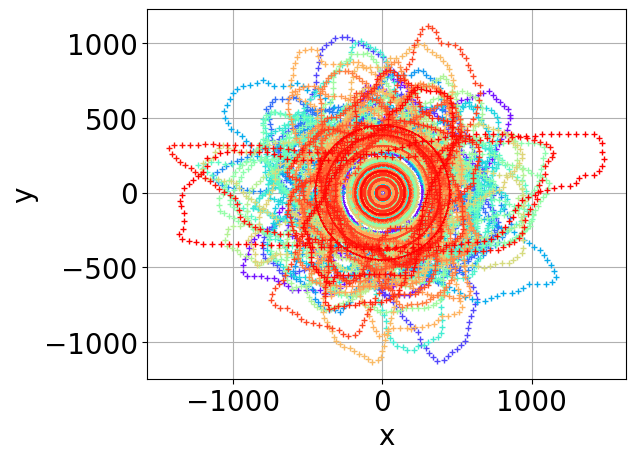

In [16]:
fig, axs3 = plt.subplots()
plt.rc('font', family='Arial') 
plt.rcParams["figure.figsize"] = (10, 10)
axs3.set_aspect('equal')
color=iter(cm.rainbow(np.linspace(0,1,len(mylist[:]))))

for n in np.arange(0,len(mylist)):
    c = next(color)
    l1,=axs3.plot(x0.iloc[:,n], y0.iloc[:,n], label=' ', linestyle='-', color=c, 
             marker='+', markersize=5, markerfacecolor='r',linewidth=0)
    l2,=axs3.plot(x1c.iloc[:,n], y1c.iloc[:,n], label=' ', linestyle='-', color=c, 
             marker='x', markersize=1, markerfacecolor='r',linewidth=1)

axs3.tick_params(axis="x", labelsize=20)
axs3.tick_params(axis="y", labelsize=20)

plt.xlabel('x',fontsize=20)
plt.ylabel('y',fontsize=20)
plt.grid(True)
#plt.savefig('fig-.png',dpi=300,bbox_inches='tight')
plt.show()

In [17]:
df = std_image(mylist)

In [53]:
x = []
y = []

for i in range len(df):
    A = 